### 폰트 설치

In [1]:
!apt-get -qq install fonts-nanum

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


### 필요 라이브러리 불러오기

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib_inline.backend_inline
import os

import numpy as np
import pandas as pd
import matplotlib.pylab as plb

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper")
sns.set_palette("Set2")
sns.set_style("whitegrid")
plt.rcParams["axes.unicode_minus"] = False

#폰트 설치 및 지정
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# 필요 함수 정의

def PCA_plot(df, n_components=2, size_of_arrow=20, arrow_font_size=10):
    # 데이터를 Standard Scaling
    scaler = StandardScaler()
    horse_scaling = scaler.fit_transform(df.drop(columns="착순"))

    # PCA 수행
    pca = PCA(n_components=n_components)
    horse_pca = pca.fit_transform(horse_scaling)

    # PCA 결과를 DataFrame으로 변환
    pca_df = pd.DataFrame(data=horse_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df["착순"] = df["착순"].values

    # 착순이 1인 데이터와 0인 데이터를 각각 1000개씩 샘플링 (if available)
    pca_df.dropna(inplace=True)
    pca_df_1 = pca_df[pca_df['착순'] == 1].sample(min(5000, len(pca_df[pca_df['착순'] == 1])))
    pca_df_0 = pca_df[pca_df['착순'] == 0].sample(min(5000, len(pca_df[pca_df['착순'] == 0])))
    pca_df = pd.concat([pca_df_1, pca_df_0], axis=0)

    # 착순 컬럼을 숫자로 변환하여 matplotlib에서 사용할 수 있도록 합니다.
    pca_df['color'] = pca_df["착순"].map({0: 0, 1: 1})

    # 각 피처의 주성분 로딩(방향성) 계산
    loadings = pca.components_.T

    # 시각화
    fig, ax = plt.subplots(figsize=(8, 8))
    scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], s=15, c=pca_df['color'], alpha=0.1, cmap='bwr')

    # 피처 로딩 벡터를 화살표로 시각화
    for i, feature in enumerate(df.drop(columns="착순").columns):
        ax.arrow(0, 0, loadings[i, 0] * size_of_arrow, loadings[i, 1] * size_of_arrow,
                 color="black", alpha=0.5, head_width=0.05, head_length=0.1)
        ax.text(loadings[i, 0] * size_of_arrow, loadings[i, 1] * size_of_arrow, feature, color='black', ha='center', va='center', fontsize=arrow_font_size)

    # 범례 추가
    legend1 = ax.legend(*scatter.legend_elements(), title="착순")
    ax.add_artist(legend1)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Horse Race Data')
    plt.grid(True)
    plt.show()

### 구글 드라이브 마운트

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

### xlsx 파일 to csv

자료 출처 : https://www.data.go.kr/data/15116930/fileData.do

In [5]:
# horse_run = pd.read_excel("한국마사회_경주상세정보(제주_부경)_20230720.xlsx")
# horse_run.columns = horse_run.loc[0]
# horse_run = horse_run.drop(index=0)
# horse_run.to_csv("horse_to.csv")

### 구글 드라이브 마운트후 경로

In [6]:
# 경고뜨는이유, 결측값이 '-'로 되어있기때문에 숫자값의 피쳐가 object로 되어있다.
# 이후에 dtype 처리
horse_run = pd.read_csv("data\horse_to.csv")

C:\Users\crazy\AppData\Local\Temp\ipykernel_7272\3704904273.py:3: DtypeWarning: Columns (4,36) have mixed types. Specify dtype option on import or set low_memory=False.
  horse_run = pd.read_csv("data\horse_to.csv")


https://knetz.kra.co.kr/infoHowGetWinHorse.do


잘 뛰는 말 고르기
경주성적이 좋은 말 : ① ② 참조

경주기록이 빠른 말 : ③ ④ ⑤ 참조 (해당 거리에서 기록이 빠른 말이나 최근 경주에서 빠른 기록을 달성한 말)

과거 경주에서 우승했을 때 뒷말과 차이가 많이 난 말 : ⑤ ⑥ 참조

부담중량이 높은 말: ⑦ 참조

선행말은 단거리(1000m~1300m)일 때, 안쪽 번호일 때, 경주로 상태가 불량할 때 유리: ⑧ ⑨ ⑩ 참조

* 아래사항들을 체크해 보고 예시장이나 경주로에서 말의 컨디션이나 걸음걸이를 확인하기
- 과거에 같은 경주에 출전해서 누가 이겼는지
- 한 달에 한 번 출전하는 정상적인 출전간격(4주 또는 5주)인지 아닌지
- 말 체중이 10kg을 초과해서 줄어있거나 늘어있지는 않은지
좋은선수 판단하기
통산 우승횟수가 많고 통산 승률이 높은 선수: ⑪ 참조

최근 1년간 우승횟수가 많은 선수: ⑪ 참조

해당마에 기승하여 좋은 성적을 거둔 선수: ⑫ 참조

### 선택 컬럼

In [7]:
horse_run.columns

Index(['Unnamed: 0', '경마장', '경주일자', '경주번호', '경주거리', '경주등급', '날씨', '주로상태(함수율)',
       '착순', '출주번호', '마명', '마번', '출신국가', '국산외산구분', '마필연령', '마필성별', '경주기록(초)',
       '경주마통산1착횟수', '경주마통산2착횟수', '경주마통산출전횟수', '경주마최근1년1착횟수', '경주마최근1년2착횟수',
       '경주마최근1년출전횟수', '마체중및증감', '부담중량', '기수명', '기수번호', '기수연령', '기수경력(년)',
       '기수통산1착횟수', '기수통산2착횟수', '기수통산출전횟수', '기수최근1년간1착횟수', '기수최근1년간2착횟수',
       '기수최근1년간출전횟수', '조교사명', '조교사번호', '조교사연령(비공개)', '조교사경력(년)', '조교사통산1착횟수',
       '조교사통산2착횟수', '조교사통산출전횟수', '조교사최근1년간1착횟수', '조교사최근1년간2착횟수',
       '조교사최근1년간출전횟수', '조교사위탁경주마1위횟수', '조교사위탁경주마2위횟수', '조교사위탁경주마출전횟수',
       '서울,제주S1F구간통과순위(서울,제주공통)', '서울,제주1코너구간통과순위(서울,제주공통)',
       '서울,제주2코너구간통과순위(서울,제주공통)', '서울,제주3코너구간통과순위(서울,제주공통)',
       '서울,제주G3F구간통과순위(서울,제주공통)', '서울,제주4코너구간통과순위(서울,제주공통)',
       '서울,제주G1F구간통과순위(서울,제주공통)', '서울S1F통과누적기록', '서울1코너통과누적기록', '서울2코너통과누적기록',
       '서울3코너통과누적기록', '서울3코너통과누적기록.1', '서울4코너통과누적기록', '서울G1F통과누적기록',
       '제주S-1F통과기록', '제주1코너통과기록', '제주2코너통과기록', '제주3코너통과기록', '제주G-3F통과기록',
 

In [8]:
# 팀원들의 의견을 모아 선택한 피쳐들
selected_col = [
 '착순',
 '경주마최근1년1착횟수',
 '경주마최근1년2착횟수',
 '경주마최근1년출전횟수',
 '경주마통산1착횟수',
 '경주마통산2착횟수',
 '경주마통산출전횟수',
 '국산외산구분',
 '기수경력(년)',
 '기수최근1년간1착횟수',
 '기수최근1년간2착횟수',
 '기수최근1년간출전횟수',
 '기수통산1착횟수',
 '기수통산2착횟수',
 '기수통산출전횟수',
 '마체중및증감',
 '마필성별',
 '마필연령',
 '부담중량',
 '조교사경력(년)',
 '주로상태(함수율)',
 '출주번호']
horse_run_selected = horse_run[selected_col]
# horse_run_selected.isna().sum() # 결측치 확인

In [9]:
# 이 데이터에서는 결측값이 - 로 나타나와 있기때문에 아래의 방법으로 결측값을 제거합니다.
horse_run_ = horse_run_selected[horse_run_selected["주로상태(함수율)"] != "-"]

In [10]:
# 결측 제거후의 데이터 타입들
horse_run_.dtypes

착순               int64
경주마최근1년1착횟수      int64
경주마최근1년2착횟수      int64
경주마최근1년출전횟수      int64
경주마통산1착횟수        int64
경주마통산2착횟수        int64
경주마통산출전횟수        int64
국산외산구분          object
기수경력(년)          int64
기수최근1년간1착횟수      int64
기수최근1년간2착횟수      int64
기수최근1년간출전횟수      int64
기수통산1착횟수         int64
기수통산2착횟수         int64
기수통산출전횟수         int64
마체중및증감          object
마필성별            object
마필연령             int64
부담중량           float64
조교사경력(년)       float64
주로상태(함수율)       object
출주번호             int64
dtype: object

In [11]:
# 주로 상태를 퍼센트로 변경
horse_run_ = horse_run_.copy()
humid = [int(j.replace('%)',''))/100 for _, j in horse_run_["주로상태(함수율)"].str.split('(')]
horse_run_.loc[:, "습도"] = humid

In [12]:
horse_run_ = pd.concat([horse_run_,pd.get_dummies(horse_run_["국산외산구분"], drop_first=True)],axis=1)
horse_run_ = pd.concat([horse_run_,pd.get_dummies(horse_run_["마필성별"], drop_first=True)],axis=1)

In [13]:
horse_run_.columns

Index(['착순', '경주마최근1년1착횟수', '경주마최근1년2착횟수', '경주마최근1년출전횟수', '경주마통산1착횟수',
       '경주마통산2착횟수', '경주마통산출전횟수', '국산외산구분', '기수경력(년)', '기수최근1년간1착횟수',
       '기수최근1년간2착횟수', '기수최근1년간출전횟수', '기수통산1착횟수', '기수통산2착횟수', '기수통산출전횟수',
       '마체중및증감', '마필성별', '마필연령', '부담중량', '조교사경력(년)', '주로상태(함수율)', '출주번호', '습도',
       '외산', '수', '암'],
      dtype='object')

In [14]:
horse_run_

,착순,경주마최근1년1착횟수,경주마최근1년2착횟수,경주마최근1년출전횟수,경주마통산1착횟수,경주마통산2착횟수,경주마통산출전횟수,국산외산구분,기수경력(년),기수최근1년간1착횟수,...,마필성별,마필연령,부담중량,조교사경력(년),주로상태(함수율),출주번호,습도,외산,수,암
0,1,1,0,2,1,0,2,국산,9,64,...,거,3,55.0,27.0,포화 (18%),9,0.18,0,0,0
1,2,0,1,5,0,1,5,국산,13,26,...,암,3,54.0,29.0,포화 (18%),2,0.18,0,0,1
2,3,0,0,5,0,0,5,국산,18,69,...,수,4,55.0,27.0,포화 (18%),3,0.18,0,1,0
3,4,0,0,3,0,0,3,국산,6,28,...,암,2,54.0,27.0,포화 (18%),6,0.18,0,0,1
4,5,0,0,6,0,0,6,국산,27,18,...,암,3,53.0,32.0,포화 (18%),1,0.18,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63288,9,0,0,0,4,3,32,국산,11,8,...,거,4,51.0,19.0,건조 (3%),10,0.03,0,0,0
63289,10,0,0,0,3,4,20,국산,9,0,...,수,5,52.0,11.0,건조 (3%),12,0.03,0,1,0
63290,11,0,0,0,5,4,32,국산,13,2,...,거,7,55.0,15.0,건조 (3%),6,0.03,0,0,0
63291,11,0,0,0,5,4,32,국산,33,2,...,거,7,55.0,15.0,건조 (3%),6,0.03,0,0,0


In [15]:
# 피쳐를 체중과, 증감량으로 분화 시키기
weights =[]
diffs = []
for weight, diff in horse_run_["마체중및증감"].str.split('('):
    weights.append(int(weight))
    if diff.replace(')','') == '':
        diffs.append(0)
    else:
        diffs.append(int(diff.replace(')','')))

In [16]:
horse_run_["무게"] = weights
horse_run_["무게 증감량"] = diffs

In [17]:
# 정제한피쳐 정리
horse_run_.drop(columns=['마체중및증감','주로상태(함수율)','마필성별', '국산외산구분'],inplace=True)

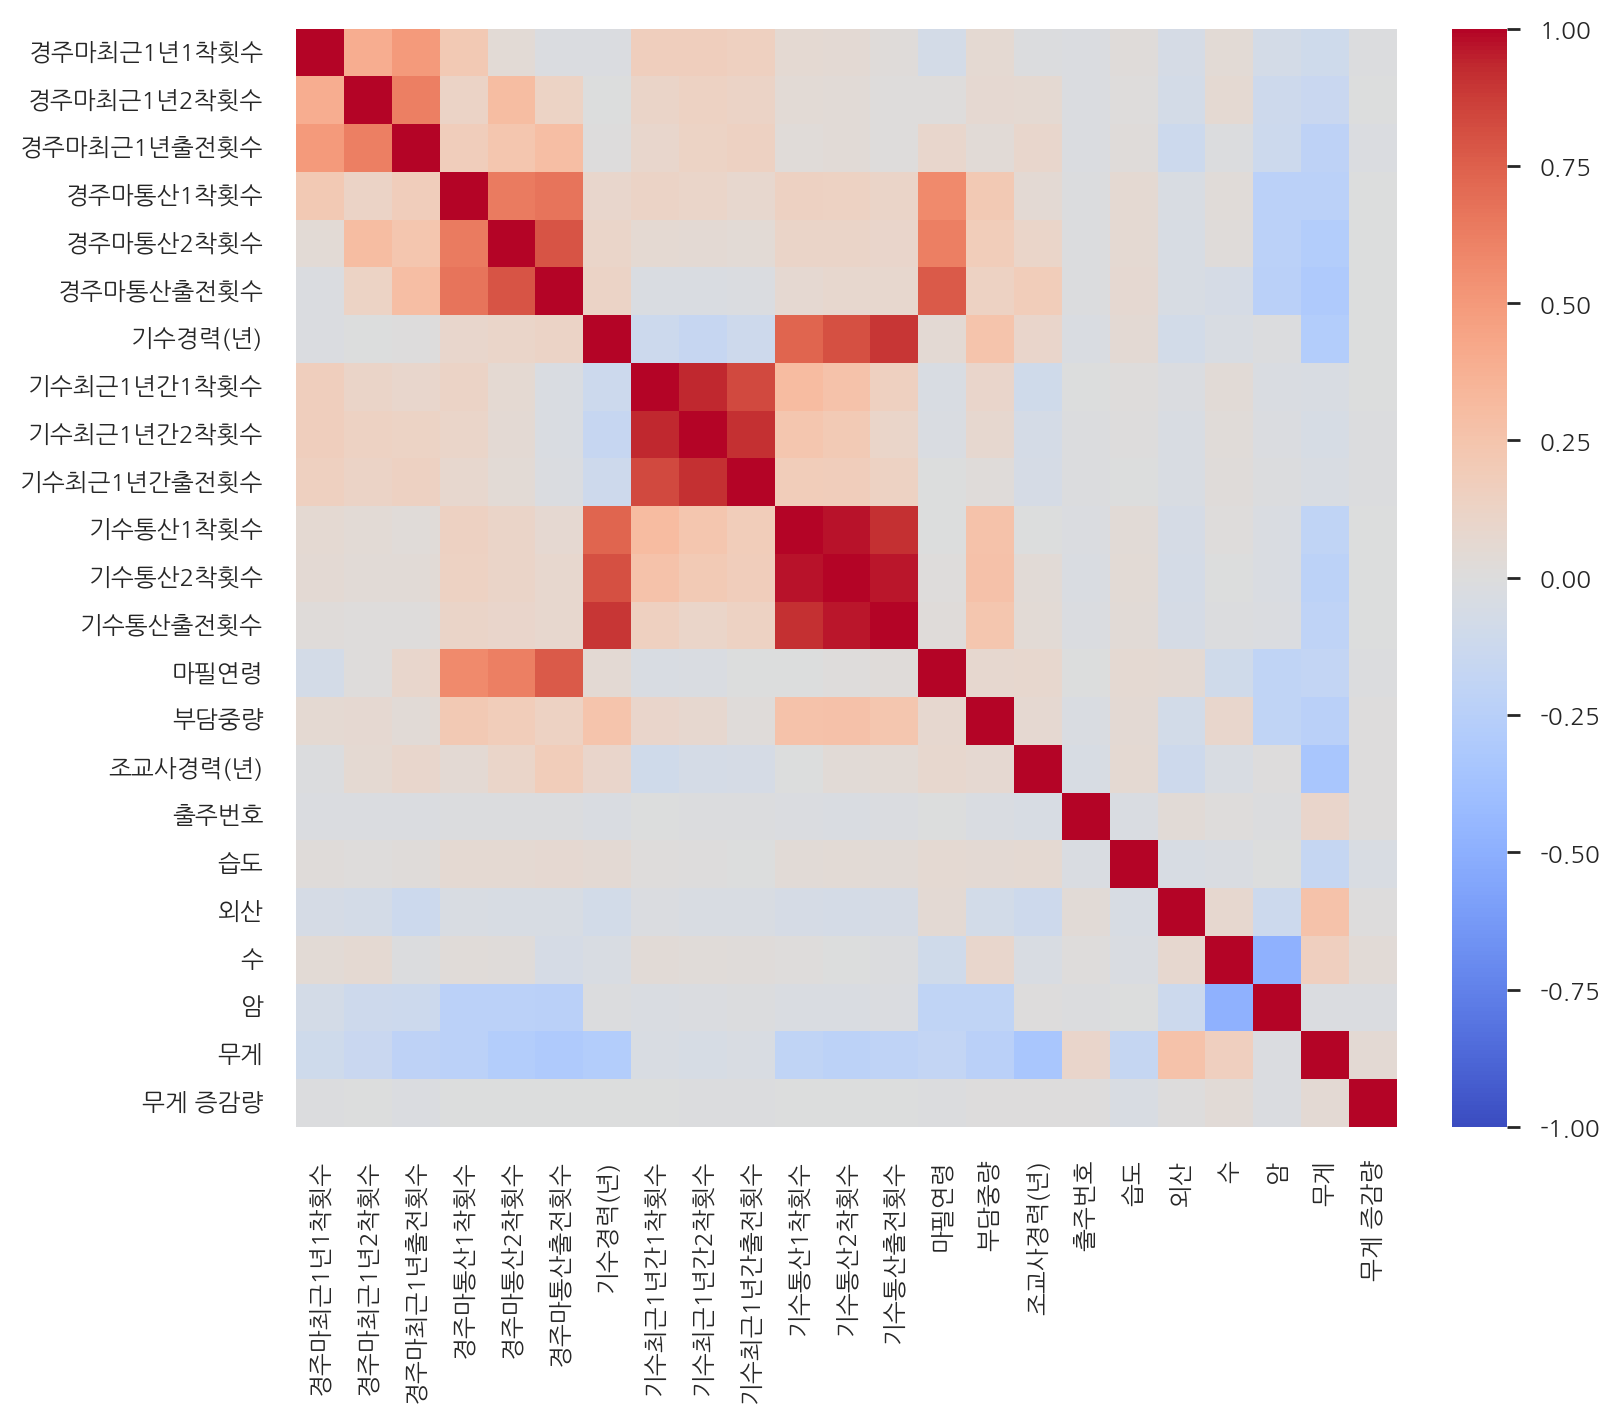

In [18]:
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(horse_run_.iloc[:,1:].corr(),
            cmap='coolwarm',
            vmax=1,
            vmin=-1,
            ax=ax);

### 연관성 분석 결과
- 1. 마필연령, 통산 1착횟수, 통산 2착횟수, 통산 출전횟수의 연관성이 너무 커보인다.

- 2. 최근 1년 1착횟수, 최근 1년 2착횟수, 최근 1년 출전 횟수의 연관성이 너무 커보인다.

- 3. 기수 관련 정보도 마찬가지
- 4. 조교사 관련 정보.
    - 조교사 경력, 통산 1착, 통산 2착, 통산출전
    - 최근 1년간 1착, 2착, 출전
    - 위탁 경주바 1위 횟수, 2위 횟수, 출전 횟수

### 수정 의견
- 마필 연령을 빼고, $ \frac{통산 1착}{통산 출전} \space 과 \space \frac{통산 2착}{통산 출전}  $ 둘중 하나 또는 둘다 넣는다

- 기수 연령과 경력을 빼고, $ \frac{통산 1착}{통산 출전} \space 과 \space \frac{통산 2착}{통산 출전}  $ 둘중 하나 또는 둘다 넣는다

- 기수 연령을 빼고, $ \frac{통산 1착}{통산 출전} \space 과 \space \frac{통산 2착}{통산 출전}  $ 둘중 하나 또는 둘다 넣는다

- $ \frac{기수 최근 통산 1착}{기수 최근 통산 출전} \space 과 \space \frac{기수 최근 통산 2착}{기수 최근 통산 출전}  $ 둘중 하나 또는 둘다 넣는다

- $ \frac{조교사 최근 통산 1착}{조교사 최근 통산 출전} \space 과 \space \frac{조교사 최근 통산 2착}{조교사 최근 통산 출전}  $ 둘중 하나 또는 둘다 넣는다

- $ \frac{조교사 위탁 최근 통산 1착}{조교사 위탁 최근 통산 출전} \space 과 \space \frac{조교사 위탁 최근 통산 2착}{조교사 위탁 최근 통산 출전}  $ 둘중 하나 또는 둘다 넣는다

In [19]:
# 목표 정하기
# 목표 설정을 쉽게 하기 위해 1등한 말, 그렇지 않은 말 로 설정합니다.
# 실격된 말은 제외하고, 착순이 1위가 아닌 말의 착순을 0으로 설정
horse_run_ = horse_run_[horse_run_["착순"] < 17]  # 실격된 말은 제외
horse_run_.loc[horse_run_["착순"] > 1, "착순"] = 0

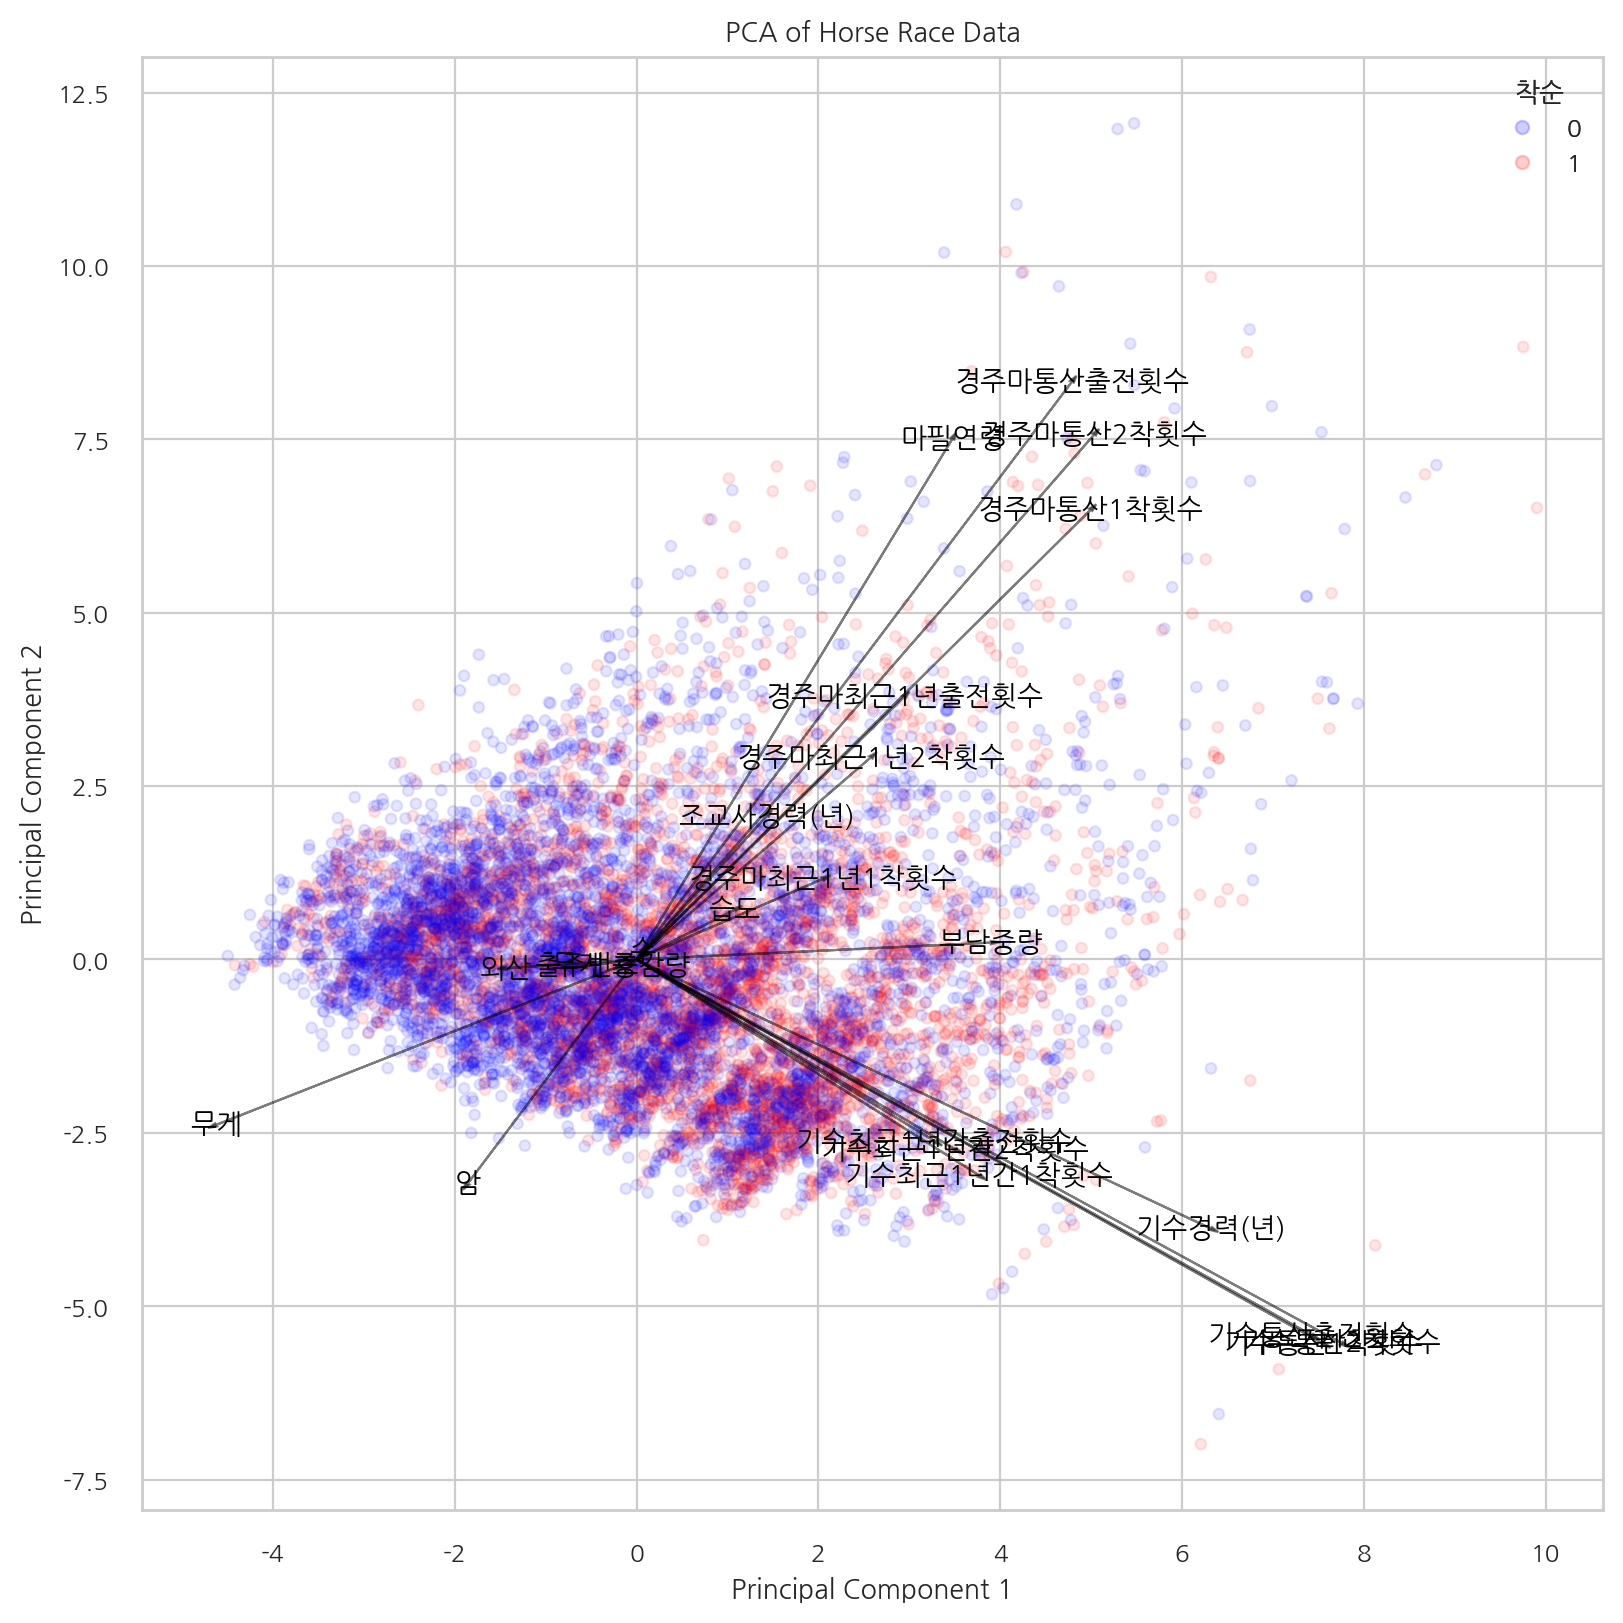

In [20]:
PCA_plot(df=horse_run_, n_components=2, size_of_arrow=20, arrow_font_size=10)

In [21]:
# 비율 계산
horse_run_ = horse_run_.copy()

horse_run_["경주마통산1착비율"] = (horse_run_["경주마통산1착횟수"] / horse_run_["경주마통산출전횟수"]).fillna(0)
horse_run_["기수통산1착비율"] = (horse_run_["기수통산1착횟수"] / horse_run_["기수통산출전횟수"]).fillna(0)

horse_run_final = horse_run_[['착순', '기수경력(년)', '마필연령', '부담중량',
       '조교사경력(년)', '출주번호', '습도', '외산', '수', '암', '무게', '무게 증감량',
       '경주마통산1착비율', '기수통산1착비율']].copy()

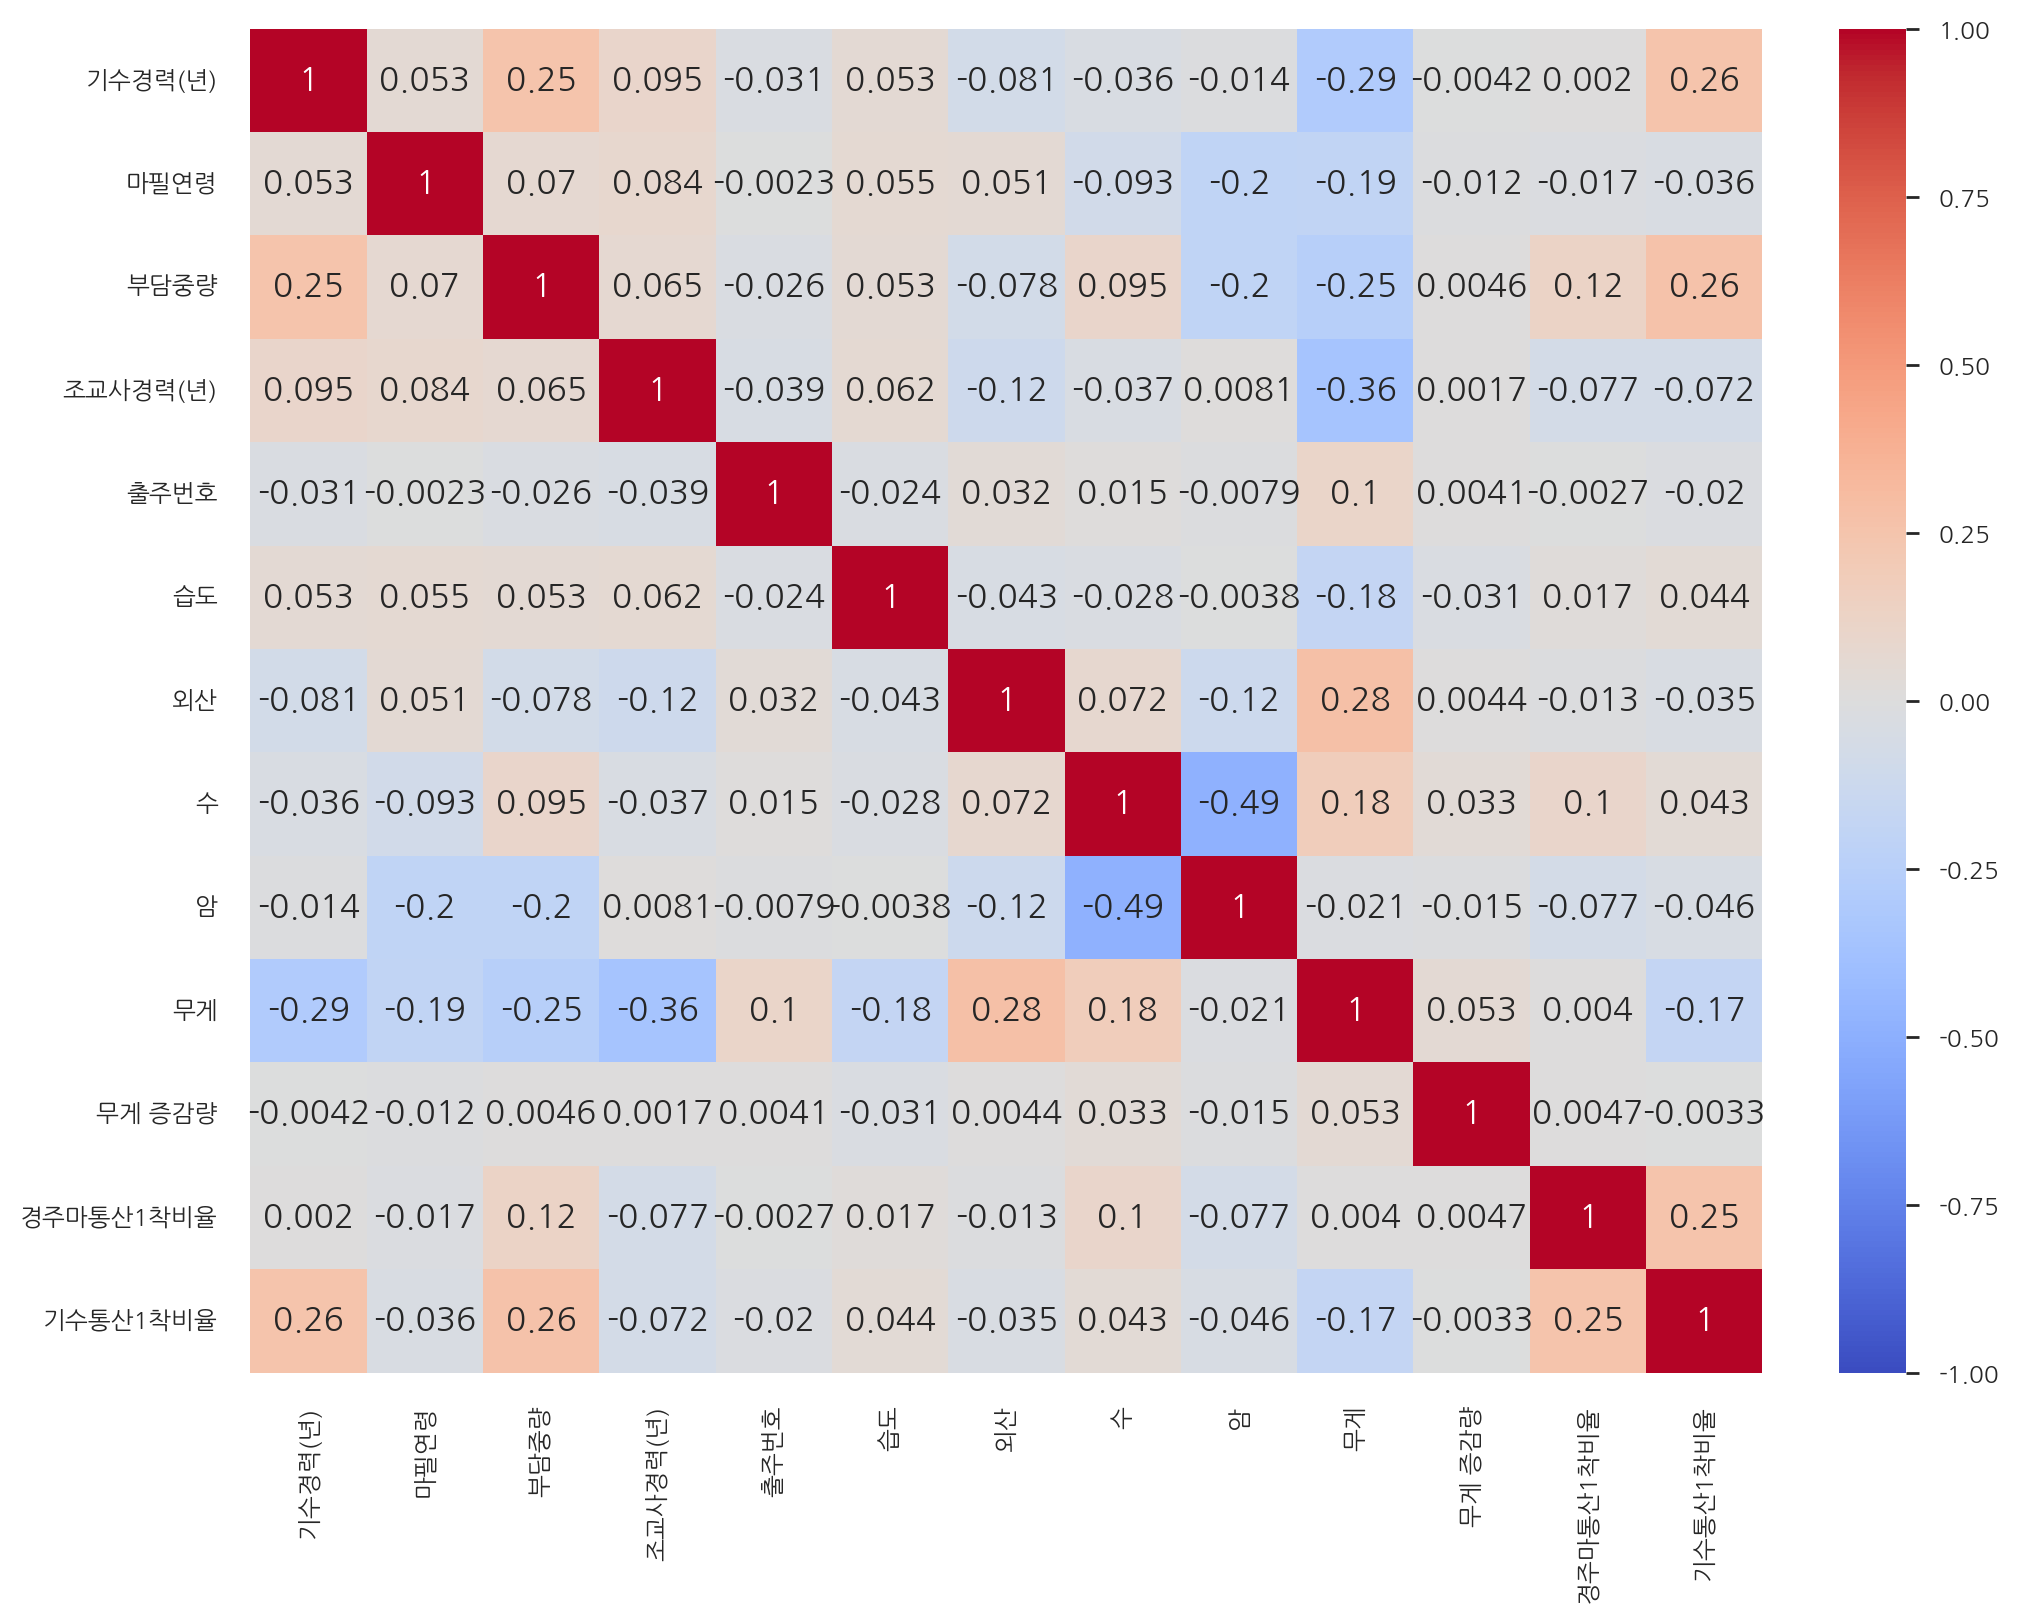

In [22]:
# 변경후 재확인
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(horse_run_final.iloc[:,1:].corr(),
            cmap='coolwarm',
            annot=True,
            annot_kws={"size": 12},
            vmax=1,
            vmin=-1,
            ax=ax);

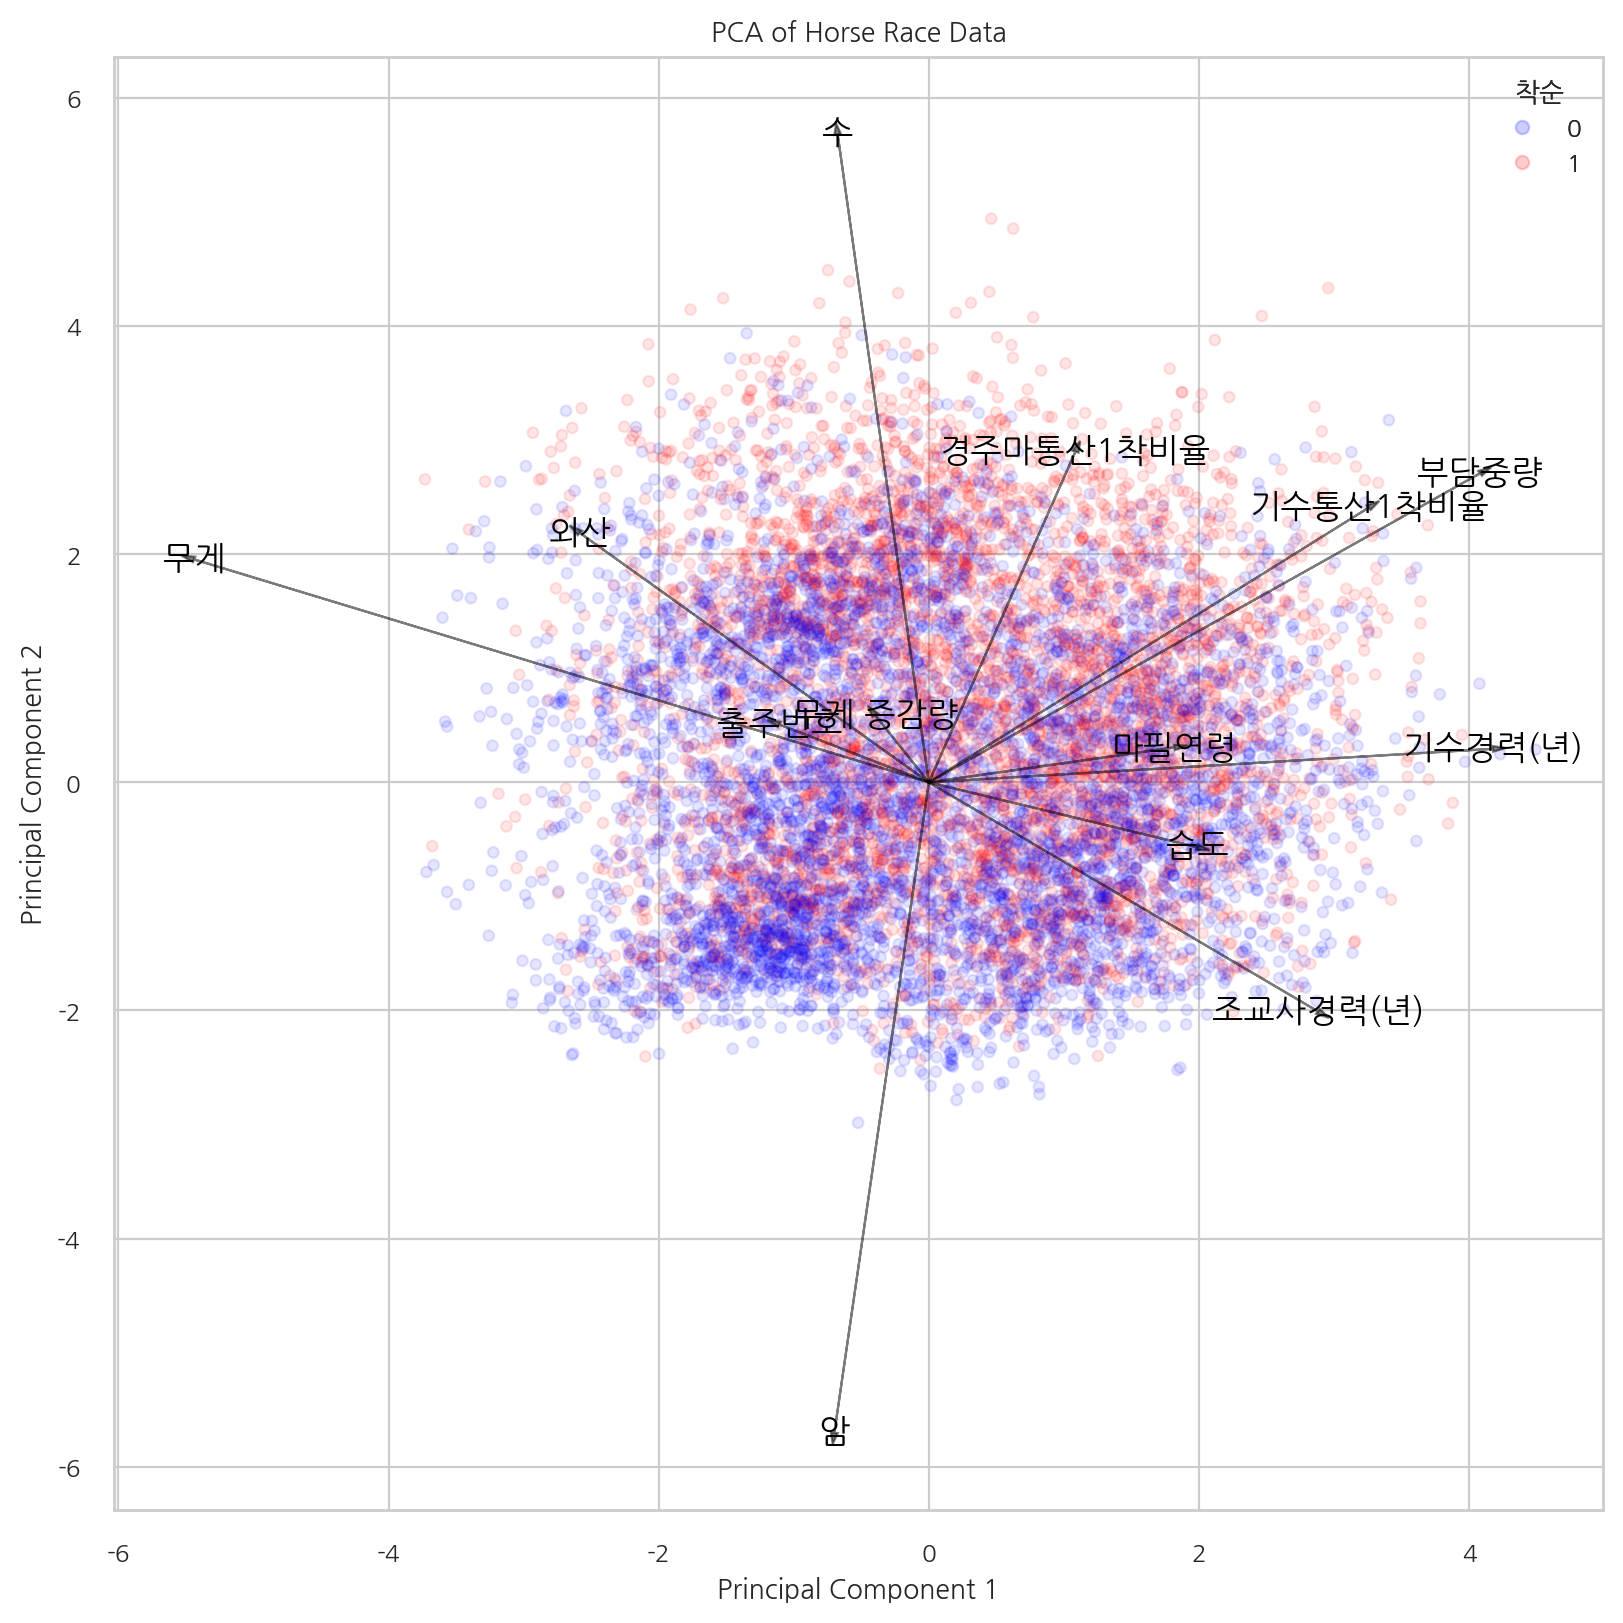

In [23]:
PCA_plot(horse_run_final, n_components=2, size_of_arrow=10, arrow_font_size=12)

In [35]:
horse_run_final

,착순,기수경력(년),마필연령,부담중량,조교사경력(년),출주번호,습도,외산,수,암,무게,무게 증감량,경주마통산1착비율,기수통산1착비율
0,1,9,3,55.0,27.0,9,0.18,0,0,0,311,-18,0.500000,0.135868
1,0,13,3,54.0,29.0,2,0.18,0,0,1,283,-6,0.000000,0.093869
2,0,18,4,55.0,27.0,3,0.18,0,1,0,271,-5,0.000000,0.156444
3,0,6,2,54.0,27.0,6,0.18,0,0,1,265,-8,0.000000,0.080102
4,0,27,3,53.0,32.0,1,0.18,0,0,1,265,-2,0.000000,0.105547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63288,0,11,4,51.0,19.0,10,0.03,0,0,0,504,6,0.125000,0.060915
63289,0,9,5,52.0,11.0,12,0.03,0,1,0,494,-9,0.150000,0.056047
63290,0,13,7,55.0,15.0,6,0.03,0,0,0,467,2,0.156250,0.063735
63291,0,33,7,55.0,15.0,6,0.03,0,0,0,467,2,0.156250,0.063735


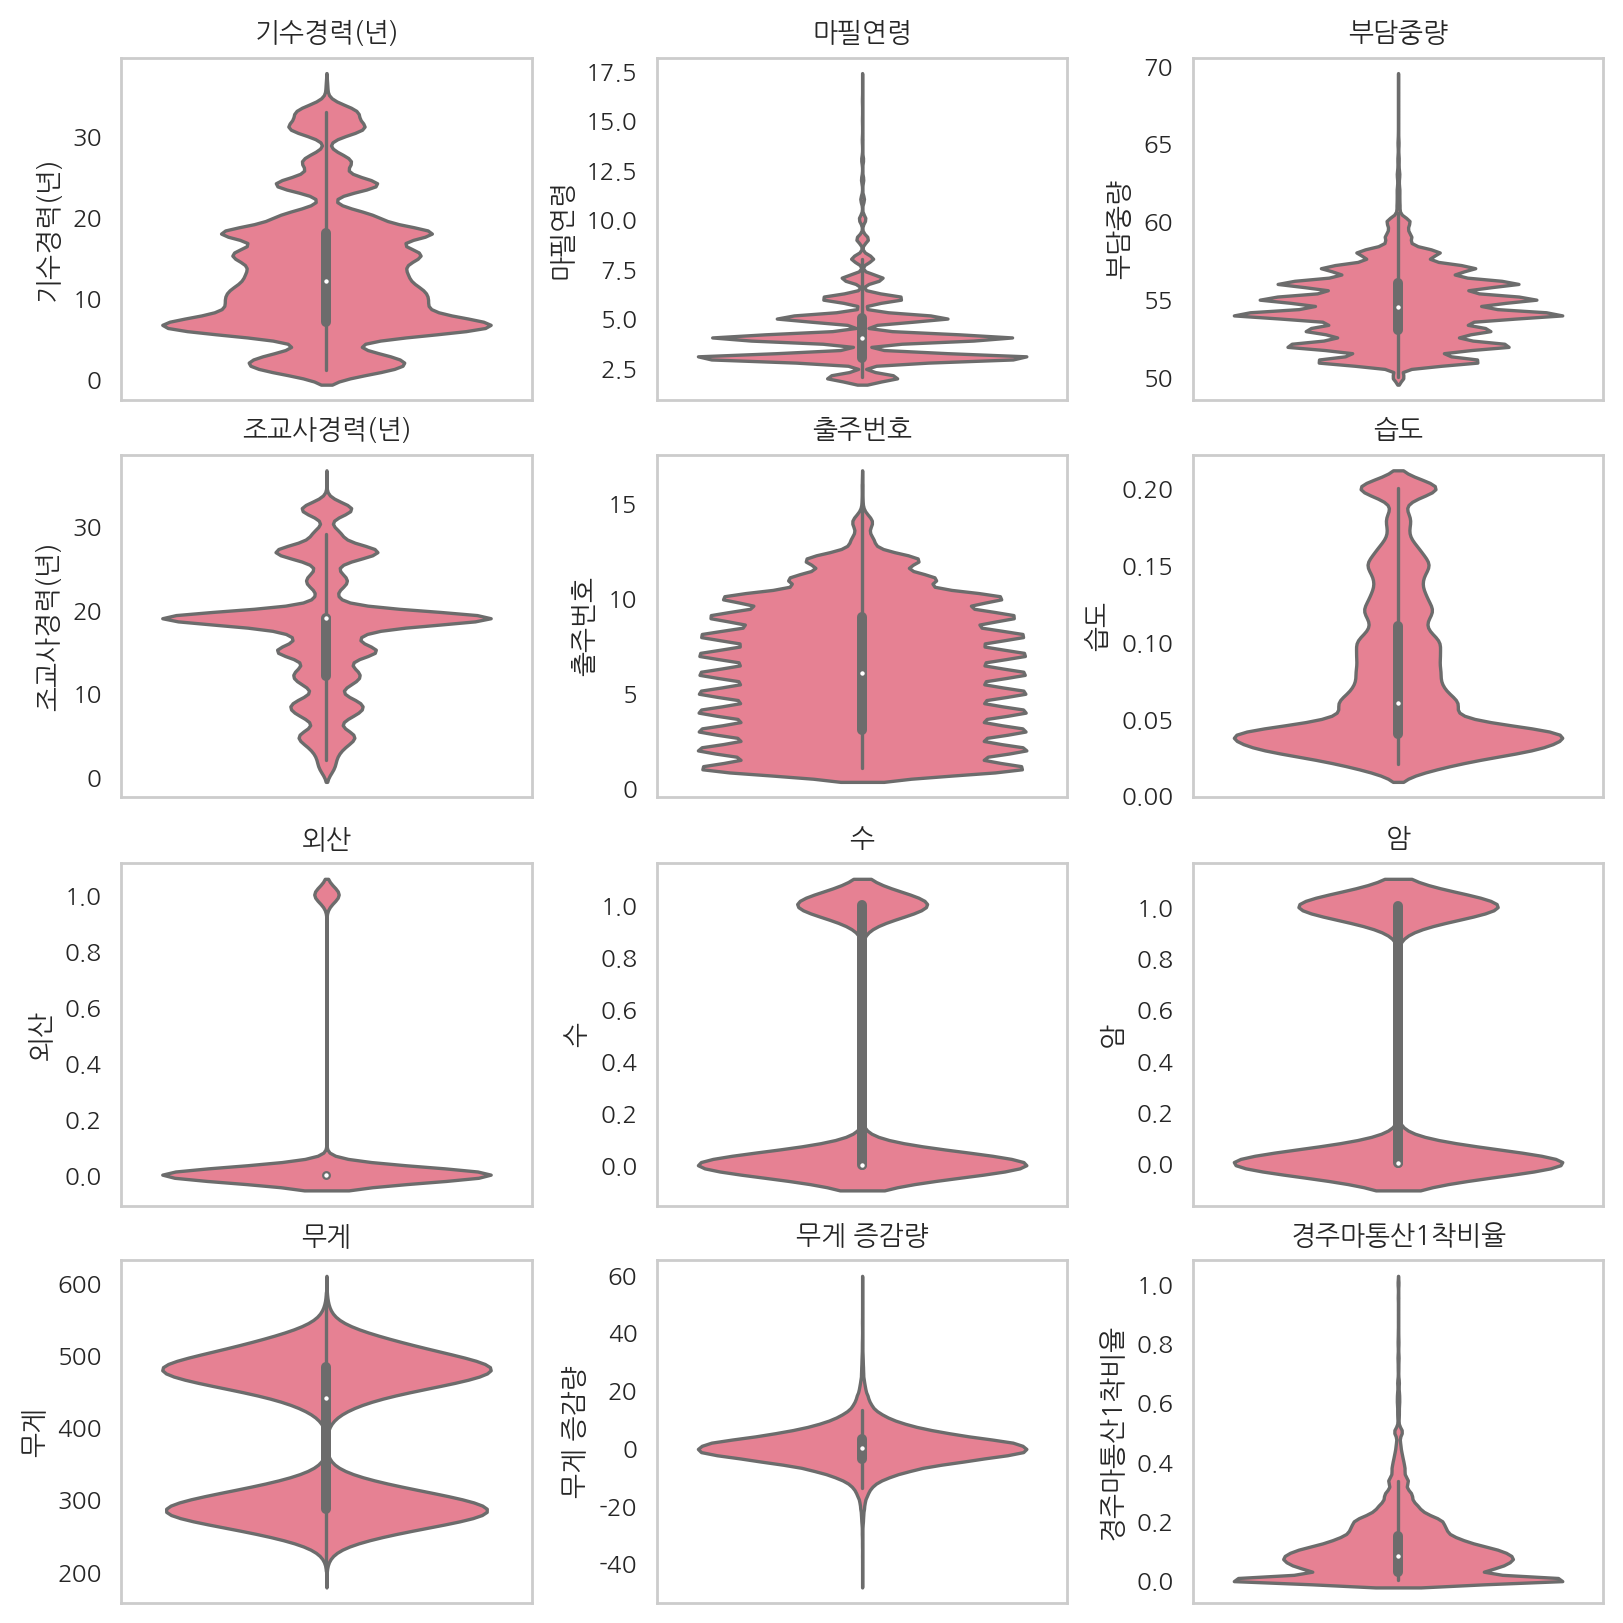

In [51]:
# 색상 팔레트 설정
palette = sns.color_palette("husl", len(horse_run_final.columns))

# 숫자형 데이터의 컬럼 수에 맞춰 subplot의 크기를 조정합니다.
fig, ax = plt.subplots(4, 3, figsize=(8, 8))
ax = ax.flatten()

# horse_run_final의 컬럼 수와 일치하도록 loop 범위를 설정합니다.
for a, i in zip(ax, range(1,len(horse_run_final))):
    sns.violinplot(data=horse_run_final,
                   y=horse_run_final.columns[i],
                   hue="착순",
                   ax=a,
                   split=True,
                   palette="husl")
    a.set_title(horse_run_final.columns[i])
    a.yaxis.set_tick_params(length=0)
    a.grid(axis="y")

# 해석
- 경주마통산1착비율과 기수통산1착비율은 착순 1에서 약간 더 높은 경향이 있습니다.
- 이는 1착 횟수가 많은 경주마와 기수가 더 높은 착순을 기록할 가능성을 시사합니다.

In [25]:
# 정리한 데이터 저장

# horse_run_final.to_csv("drive/MyDrive/horse_run_final.csv")

### 이후 계획

랜더 마이즈 서치를 통한 여러 테스트

- 교차검증
    - KNN
    - Descision Tree
    - 랜덤 포레스트
    - adaboost
    - XGBoost

- DNN

- 순서
    - 머신러닝
        - 랜더마이즈 서치 및 그리드 서치를 위한 함수 만들기
        - 의미 있는 하이퍼 파라미터 정하기
        - 실험을 하여 시각화 하기
        - 각 실험결과를 기록하기
    - 딥러닝
        - 다양한 층과 노드를 생성하여 분석해보기
        - 이진분류 (시그모이드)
